# Проект 5. Компьютер говорит нет!
Построение модели, предсказывающей вероятность дефолта по кредиту на основе данных по клиенту
## Oписания полей датасета
* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* foreign_passport - наличие загранпаспорта
* default - флаг дефолта по кредиту

# Импорт библиотек

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings("ignore")


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.under_sampling import RandomUnderSampler

from catboost import CatBoost,CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

RANDOM_SEED = 42
!pip freeze > requirements.txt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../module_5/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../module_5/data\sample_submission.csv
../module_5/data\test.csv
../module_5/data\train.csv


# Функции

In [9]:
def data_description(df: pd.DataFrame) -> None:
    ''' Выводит дополнительную информацию о пустых полях в датасете. '''

    print("Размерность набора (строки, столбцы):", df.shape, "\n")
    print("Кол-во полных дубликатов:", df[df.duplicated()].shape[0])
    print(
        "Кол-во пустых строк:     ", df[df.isna().all(axis="columns")].shape[0]
    )
    print(
        "Кол-во строк, имеющих хотя бы одно пустое значение:",
        df[df.isna().any(axis="columns")].shape[0],
    )
    print(
        "Кол-во строк, не имеющих ни одного пустого значения:",
        df[df.notna().all(axis="columns")].shape[0],
        "\n",
    )
    print("Информация о пустых значениях по столбцам (в процентах):")
    display(df.isna().mean() * 100)
    print()
    print("Информация о кол-ве уникальных значений по столбцам:")
    display(df.nunique())
    #display(df.isna().agg(['sum', 'mean']).T) 
    #print("   желтый - пропущенные данные, синий - не пустые")
    # Посмотрим как распеделены пропуски по датасету:
    #plt.figure(figsize=(10, 7)) # размер тепловой карты
    #sns.heatmap(df.isnull(), cmap="YlGnBu_r")
    return None


def field_values(df: pd.DataFrame, column: object, uval: int=15, table: bool=True) -> None :
    ''' Выводит информацию о типе данных в колонке, кол-во уникальных значений и
    кол-во NaN. А также, если кол-во уникальных значений меньше uval, выводит 
    список всех возможных значений в колонке, отcортированных по значениям, а 
    не по кол-ву, иначе сортировка по кол-ву.
    '''
    print(column,': ', type(df[column][0]))
    uniqval = df[column].nunique()
    print('Уникальных значений ', uniqval, ' из', df.shape[0] )
    print('NaN ', df[column].isna().sum(), "(",
            round(df[column].isna().mean() * 100, 2),
            "% )")
    if table:
        if uniqval > uval :
            display(df[column].value_counts().head(uval))
        else:
            display(df.groupby([column])[column].count())

    return None


def IQR_hist(df: pd.DataFrame, column: object, outliers: bool=False) -> None :
    ''' Строит гистограмму и выводит все числовые значения для оценки наличия выбросов '''

    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    iqr_low = perc25 - 1.5 * IQR
    iqr_up = perc75 + 1.5 * IQR
    min_value = df[column].min()
    max_value = df[column].max()
    print(
        "Среднее: {},".format(round(df[column].mean(), 2)),
        "Медиана: {},".format(round(df[column].median(), 2)),
        "Мода: {},".format(list(df[column].mode())),
    )
    print(
        "25-й перцентиль: {},".format(perc25),
        "75-й перцентиль: {},".format(perc75),
        "IQR: {}.".format(IQR),
    )
    print("Минимум/максимум: [{x}, {y}].".format(x=min_value, y=max_value))
    print("Границы выбросов: [{f}, {l}].".format(f=iqr_low, l=iqr_up))

    if outliers:
        ser = df[column].loc[df[column].between(min_value, max_value)].copy()
        nbins = min(100, ser.value_counts().count())
        ser.loc[(ser < iqr_low) | (ser > iqr_up)].hist(
            bins=nbins,
            range=(min_value, max_value),
            color="red",
            label="outliers",
        )
        ser.loc[ser.between(iqr_low, iqr_up)].hist(
            bins=nbins, range=(min_value, max_value), label="IQR"
        )
    else:
        min_interval = max(min_value, iqr_low)
        max_interval = min(max_value, iqr_up)
        ser = (
            df[column]
            .loc[df[column].between(min_interval, max_interval)]
            .copy()
        )
        nbins = min(100, ser.value_counts().count())
        ser.hist(bins=nbins, range=(min_interval, max_interval), label="IQR")
    plt.legend()

    return None


def show_roc_auc(y_test, y_probs):
    ''' Строит график ROC AUC '''
    
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    return None

    
def show_confusion_matrix(y_test, y_pred):
    ''' Визуализация confusion matrix '''
    
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    confusion_matrix(y_test, y_pred).flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')
    ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
    display(confusion_matrix(y_test, y_pred))
    plt.show()
    
    return None

# Данные

In [10]:
#DATA_DIR = '/kaggle/input/sf-dst-scoring/'
DATA_DIR = '../module_5/data'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [11]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [13]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [15]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [16]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [17]:
# бъединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['default'] = 0

# объединяем
data = df_test.append(df_train, sort=False).reset_index(drop=True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Предварительная обработка данных

In [18]:
data_description(data)

Размерность набора (строки, столбцы): (110148, 20) 

Кол-во полных дубликатов: 0
Кол-во пустых строк:      0
Кол-во строк, имеющих хотя бы одно пустое значение: 478
Кол-во строк, не имеющих ни одного пустого значения: 109670 

Информация о пустых значениях по столбцам (в процентах):


client_id           0.000000
app_date            0.000000
education           0.433962
sex                 0.000000
age                 0.000000
car                 0.000000
car_type            0.000000
decline_app_cnt     0.000000
good_work           0.000000
score_bki           0.000000
bki_request_cnt     0.000000
region_rating       0.000000
home_address        0.000000
work_address        0.000000
income              0.000000
sna                 0.000000
first_time          0.000000
foreign_passport    0.000000
sample              0.000000
default             0.000000
dtype: float64


Информация о кол-ве уникальных значений по столбцам:


client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

В целом наш набор выглядит неплохо. Пропуски есть только в колонке **education** и их всего 478 из 110148 строк, что составляет 0.43%

С учетом всего, что мы уже знаем предварительно разделим колонки по типу признака:

In [19]:
# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные признаки
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
# числовые признаки
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

### Education (пропуски данных)

In [20]:
# Посмотрим на значения в education столбце
field_values(data, 'education')

education :  <class 'str'>
Уникальных значений  5  из 110148
NaN  478 ( 0.43 % )


education
ACD      291
GRD    34768
PGR     1865
SCH    57998
UGR    14748
Name: education, dtype: int64

In [21]:
#Заполним пропуски наиболее часто встречающимся "SCH"
data.education.fillna('SCH', inplace=True)

### Default (целевая переменная)

default :  <class 'numpy.int64'>
Уникальных значений  2  из 73799
NaN  0 ( 0.0 % )


default
0    64427
1     9372
Name: default, dtype: int64

<AxesSubplot:>

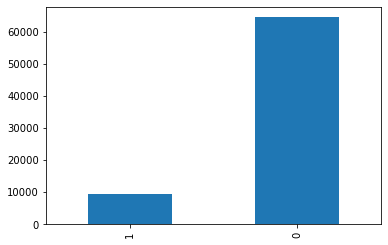

In [22]:
# Посмотрим на значения в этом столбце по df_train 
#  (в части df_test целевой переменной Rating нет)
field_values(df_train,'default')
# и распределение целевой переменной
df_train['default'].value_counts(ascending=True).plot(kind='bar')

"Хороших" клиентов значительно больше)) но это означает, что выборка несбалансированная

## Числовые признаки

### age (числовой признак)

Среднее: 39.25, Медиана: 37.0, Мода: [31],
25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0.
Минимум/максимум: [21, 72].
Границы выбросов: [3.0, 75.0].


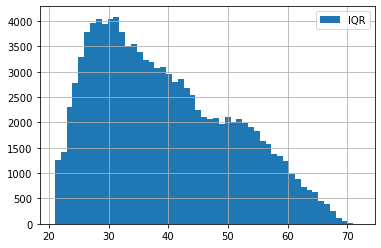

In [23]:
col='age'
IQR_hist(data, col)

выбросов нет, оставим все как есть.

### decline_app_cnt (числовой признак)

decline_app_cnt :  <class 'numpy.int64'>
Уникальных значений  24  из 110148
NaN  0 ( 0.0 % )


0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
Name: decline_app_cnt, dtype: int64

Среднее: 0.27, Медиана: 0.0, Мода: [0],
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0.
Минимум/максимум: [0, 33].
Границы выбросов: [0.0, 0.0].


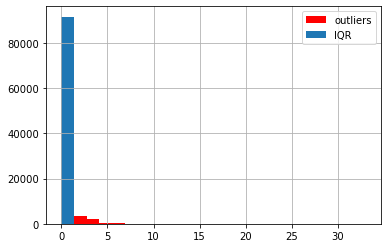

In [24]:
col='decline_app_cnt'
field_values(data, col)
IQR_hist(data, col, True)

In [25]:
#data.loc[data[col] > 4, col] = 4

# Переведем decline_app_cnt в катеогрию "категоральные", т.к. в дальнейшем это влияет на метрики модели
#cat_cols.append(col)
#num_cols.remove(col)

Пробовала превратить в категоральный, логарифмировать. Лучше не становилось. Оставила как есть. 

### score_bki (числовой признак)

score_bki :  <class 'numpy.float64'>
Уникальных значений  102618  из 110148
NaN  0 ( 0.0 % )


-1.775263    517
-2.104211    454
-2.225004    424
-2.169664    375
-2.024100    278
-1.920823    270
-2.387268    238
-2.447239    207
-1.526422    207
-2.272941    176
-2.353052    170
-2.418505    163
-2.315224    155
-2.473844     55
-1.087287     45
Name: score_bki, dtype: int64

Среднее: -1.9, Медиана: -1.92, Мода: [-1.77526279],
25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004.
Минимум/максимум: [-3.62458632, 0.19977285].
Границы выбросов: [-3.299251946250001, -0.5290698762499992].


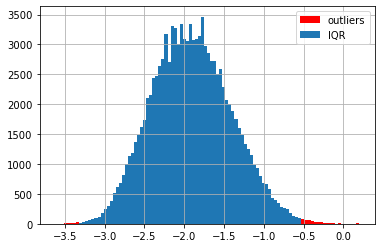

In [26]:
col='score_bki'
field_values(data, col)
IQR_hist(data, col, True)

распределение вполне себе нормальное. есть небольшие выбросы, но удалять не будем.

### bki_request_cnt (числовой признак)

bki_request_cnt :  <class 'numpy.int64'>
Уникальных значений  40  из 110148
NaN  0 ( 0.0 % )


0    28908
1    27295
2    20481
3    13670
4     8406
5     4960
6     2500
7     1292
8      735
9      459
Name: bki_request_cnt, dtype: int64

Среднее: 2.01, Медиана: 1.0, Мода: [0],
25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0.
Минимум/максимум: [0, 53].
Границы выбросов: [-4.5, 7.5].


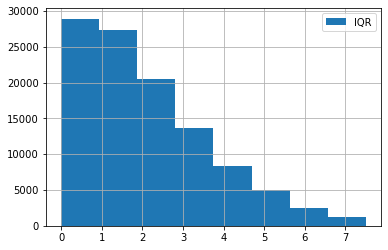

In [27]:
col='bki_request_cnt'
field_values(data, col, 10)
IQR_hist(data, col)

<AxesSubplot:>

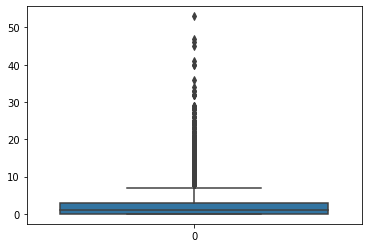

In [28]:
sns.boxplot(data=data[col])

<AxesSubplot:>

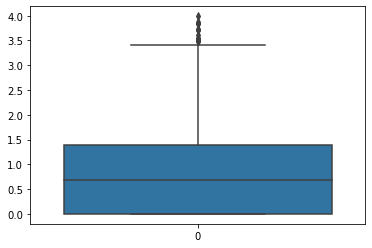

In [29]:
sns.boxplot(data=data[col].apply(lambda x: np.log(x + 1)))

bki_request_cnt :  <class 'numpy.float64'>
Уникальных значений  40  из 110148
NaN  0 ( 0.0 % )


0.000000    28908
0.693147    27295
1.098612    20481
1.386294    13670
1.609438     8406
1.791759     4960
1.945910     2500
2.079442     1292
2.197225      735
2.302585      459
Name: bki_request_cnt, dtype: int64

Среднее: 0.88, Медиана: 0.69, Мода: [0.0],
25-й перцентиль: 0.0, 75-й перцентиль: 1.3862943611198906, IQR: 1.3862943611198906.
Минимум/максимум: [0.0, 3.9889840465642745].
Границы выбросов: [-2.0794415416798357, 3.465735902799726].


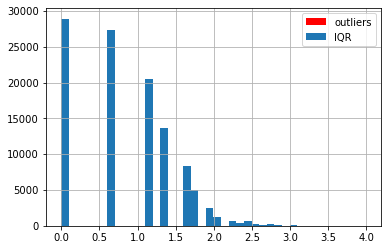

In [30]:
data[col] = data[col].apply(lambda x: np.log(x +1))
field_values(data, col, 10)
IQR_hist(data, col, True)

Прологарифмировали.

### region_rating (числовой признак)

region_rating :  <class 'numpy.int64'>
Уникальных значений  7  из 110148
NaN  0 ( 0.0 % )


region_rating
20      313
30      434
40    17947
50    40981
60    23999
70     9304
80    17170
Name: region_rating, dtype: int64

Среднее: 56.75, Медиана: 50.0, Мода: [50],
25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0.
Минимум/максимум: [20, 80].
Границы выбросов: [35.0, 75.0].


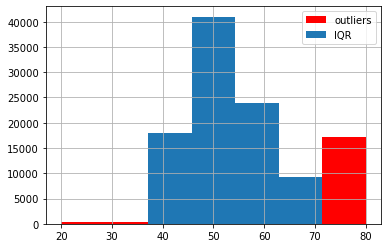

In [31]:
col = 'region_rating'
field_values(data, col)
IQR_hist(data, col, True)

есть выбросы, но они очень близко к границам. Оставим как есть.

### income (числовой признак)

income :  <class 'numpy.int64'>
Уникальных значений  1207  из 110148
NaN  0 ( 0.0 % )


30000     10437
25000      9090
20000      8174
40000      7383
50000      6742
35000      6319
15000      5874
60000      3818
45000      3670
18000      2732
70000      2421
10000      2169
100000     2056
80000      1951
12000      1728
Name: income, dtype: int64

Среднее: 41012.65, Медиана: 30000.0, Мода: [30000],
25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0.
Минимум/максимум: [1000, 1000000].
Границы выбросов: [-22000.0, 90000.0].


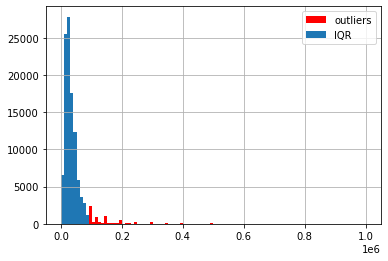

In [32]:
col='income'
field_values(data, col)
IQR_hist(data, col, True)

<AxesSubplot:>

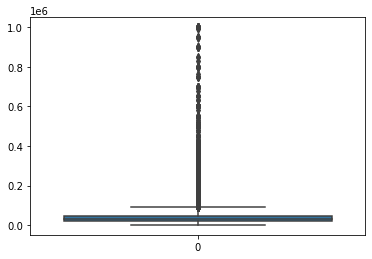

In [33]:
sns.boxplot(data=data[col])

<AxesSubplot:>

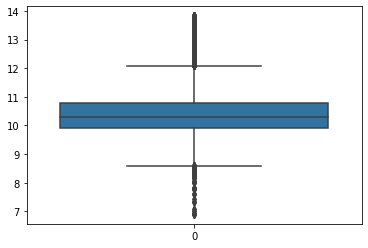

In [34]:
sns.boxplot(data=data[col].apply(lambda x: np.log(x)))

In [35]:
#data[col] = data[col].apply(lambda x: np.log(x))
#field_values(data, col, 10)
#IQR_hist(data, col, True)

опять лучше не преобразовывать данные. Результат ухудшается. Оставим как есть. 

## app_date (создадим на основе даты новые признаки)

In [36]:
# Преобразуем app_date в тип date 
data['app_date'] = pd.to_datetime(data['app_date'])

# Посмотрим период наблюдений:
data['app_date'].agg(['min', 'max'])

min   2014-01-01
max   2014-04-30
Name: app_date, dtype: datetime64[ns]

In [37]:
# наши данные только за 2014, поэтому просто не будем учитывать год
# месяц однозначно будет коррелировать с днем года, поэтому оставим только день года
#data['month'] = data['app_date'].dt.month

data['weekday'] = data['app_date'].dt.weekday
data['dayofyear'] = data['app_date'].dt.dayofyear

# Обновим наши списки признаков
num_cols.append('dayofyear')
cat_cols.append('weekday')

# удалим ставший лишним столбец с датой
data.drop(['app_date'],  axis = 1, inplace = True)

<AxesSubplot:>

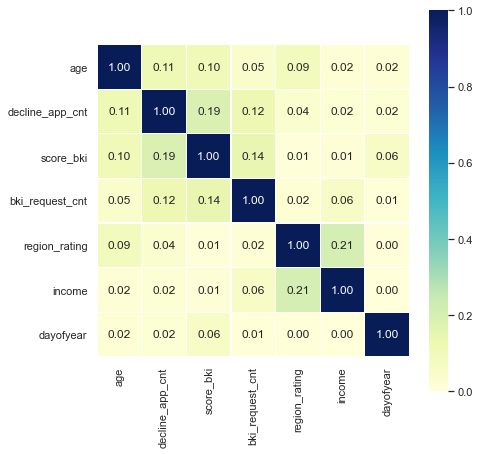

In [38]:
# Посмотрим матрицу коэффициента корреляции численных признаком
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu")

<AxesSubplot:>

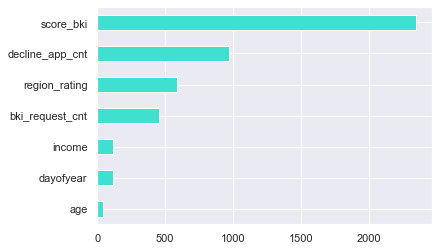

In [39]:
#оценка значимости числовых переменных
df_copy = data[data['sample'] == 1].copy()
imp_num = pd.Series(f_classif(df_copy[num_cols], df_copy['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='turquoise')

Итого, числовые признаки слабо коррелированы, оставим все, самым значимым из числовых является score_bki, наименее важный - sex.

## Бинарные признаки

In [40]:
data[bin_cols].sample(3)

,sex,car,car_type,good_work,foreign_passport
63039,M,N,N,0,N
55864,F,Y,Y,0,N
118,F,N,N,0,N


In [41]:
# Закодируем все бинарные признаки 
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
data[bin_cols].sample(3)

,sex,car,car_type,good_work,foreign_passport
50374,1,1,1,1,1
50328,0,0,0,0,0
109200,0,0,0,0,1


## Категоральные признаки

In [42]:
data[cat_cols].sample(5)

,education,home_address,work_address,sna,first_time,weekday
32192,GRD,2,3,1,3,0
49088,SCH,2,3,2,1,3
100341,SCH,2,3,2,3,5
49213,SCH,2,3,1,4,2
108684,SCH,2,3,3,3,4


In [43]:
# Перекодируем education 
edu_label_encoder = LabelEncoder()

data['education'] = edu_label_encoder.fit_transform(data['education'])
print(dict(enumerate(edu_label_encoder.classes_)))
data[cat_cols].sample(5)

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


,education,home_address,work_address,sna,first_time,weekday
75009,3,2,3,1,4,3
23347,3,1,2,1,3,1
98843,4,2,3,4,3,2
51923,3,2,3,2,2,1
56304,3,1,2,4,1,2


<AxesSubplot:>

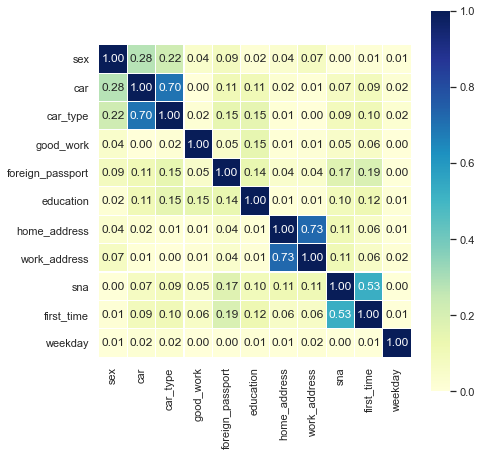

In [44]:
# Посмотрим матрицу коэффициента корреляции для бинарных и катерогиальных признаков
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sns.heatmap(data[bin_cols + cat_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu")

<AxesSubplot:>

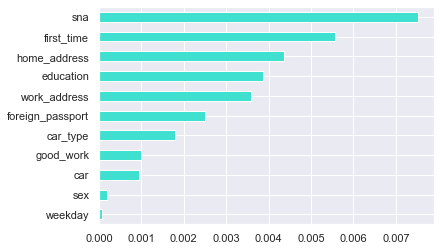

In [45]:
#оценка значимости бинарных и категориальных признаков
df_copy = data[data['sample'] == 1].copy()
imp_cat = pd.Series(mutual_info_classif(df_copy[bin_cols + cat_cols], df_copy['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color='turquoise')

Сильно коррелируют car и car_type и еще work_address и home_address.<br>
Попробуем удалить car как менее значимый, и посмотрим, что изменилось в модели (стало лучше).<br>
С адресами такое не прошло. Удалять не надо. <br>

In [46]:
data.drop(['car'], axis=1, inplace=True)
bin_cols.remove('car')

# df.drop(['work_address'], axis=1, inplace=True)
# cat_cols.remove('work_address')

In [47]:
# Выберем из датасета нужные колонки:
df_copy = data[['work_address', 'home_address']].values

# Создадим Scaler instance:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_copy)

# Из двух столбцов сделаем один путем усечения ненужной информации.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
data['hw_address'] = pca_data

# Уберем ненужные колонки:
data = data.drop(['home_address','work_address'],axis=1)

# Приведем в порядок списки:
cat_cols.remove('home_address')
cat_cols.remove('work_address')
cat_cols.append('hw_address')

In [48]:
data[cat_cols].nunique()

education     5
sna           4
first_time    4
weekday       7
hw_address    9
dtype: int64

In [49]:
# Преобразуем категориальные признаки с помощью get_dummies
data = pd.get_dummies(data, columns=cat_cols)

# Выполним стандартизацию численных переменных
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns=data[num_cols].columns)

data.sample(5)

,client_id,sex,age,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,sample,default,dayofyear,education_0,education_1,education_2,education_3,education_4,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hw_address_-2.3108715396333763,hw_address_-1.282573361994365,hw_address_-0.970536986531171,hw_address_-0.25427518435535335,hw_address_0.05776119110784036,hw_address_0.3697975665710343,hw_address_1.0860593687468518,hw_address_1.3980957442100457,hw_address_2.426393921849057
51292,35687,0,-1.584424,0,-0.341893,0,-1.928532,-1.334144,-0.516704,-0.572972,0,1,0,-0.591455,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
16575,68373,0,-1.410783,0,-0.341893,0,-0.671955,-0.281790,-1.282058,-0.506892,0,0,0,0.437354,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
100921,101733,0,0.325628,0,-0.341893,0,-1.274875,-1.334144,0.248649,-0.594998,0,1,0,1.434987,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
37746,19430,0,-0.976680,0,-0.341893,0,0.477147,-0.281790,-1.282058,-0.242572,0,1,1,-1.090271,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
97564,109137,1,1.801578,0,-0.341893,0,0.191431,0.333797,0.248649,-0.462838,0,1,0,1.777923,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Построение модели

In [50]:
# Разделим обратно на train и test и удалим sample
train = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)

X = train.drop(columns = ['default', 'client_id']).values
Y = train['default'].values 

# Разобьем данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

## Модель LogisticRegression

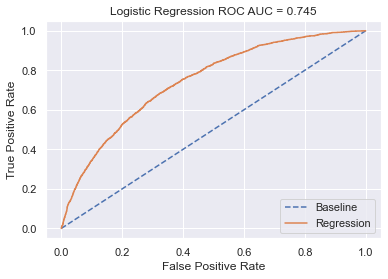

array([[12867,    66],
       [ 1789,    38]], dtype=int64)

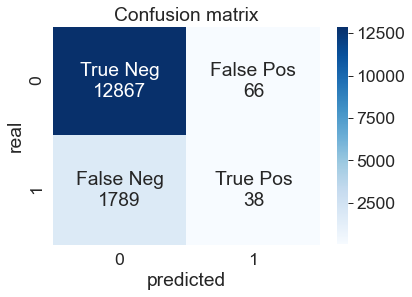

accuracy_score: 0.8743
precision_score: 0.3654
recall_score: 0.0208
f1_score: 0.0394
MSE: 0.1257


In [51]:
# Обучаем модель
model_1 = LogisticRegression(max_iter = 1000)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

# Строим ROC AUC 
probs = model_1.predict_proba(X_test)
probs = probs[:,1]
show_roc_auc(y_test,probs)

# Строим матрицу ошибок
show_confusion_matrix(y_test,y_pred)

# Остальные метрики
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('precision_score: {}'.format(np.round(precision_score(y_test,y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

Модель логистической регрессии с параметрами "по умолчанию" имеет достаточно высокую точность, однако, оценив матрицу ошибок, можно сделать вывод, что почти во всех случаях, когда клиент не способен выплатить кредит - модель все равно его выдаст. Данное решение приведет к падению доходов банка. Попробуем найти оптимальные гиперпараметры.

## Модель LogisticRegression (гиперпараметры)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.4s finished


Лучшие параметры модели:  {'C': 75.0, 'max_iter': 223}


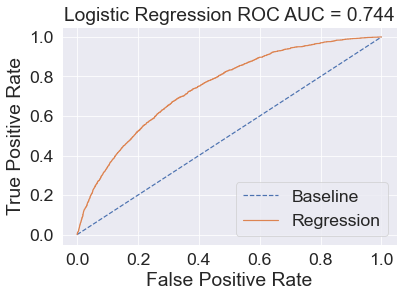

array([[8682, 4251],
       [ 572, 1255]], dtype=int64)

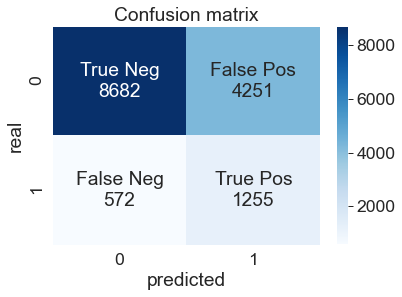

accuracy_score: 0.6732
precision_score: 0.2279
recall_score: 0.6869
f1_score: 0.3423
MSE: 0.3268


In [52]:
# Попробуем поменять class_weight и C помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)
model_best.fit(X_train, y_train)
print("Лучшие параметры модели: ", model_best.best_params_)
y_pred = model_best.predict(X_test)

probs = model_best.predict_proba(X_test)
probs = probs[:,1]
show_roc_auc(y_test, probs)


# Строим матрицу ошибок
show_confusion_matrix(y_test, y_pred)

# Остальные метрики
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('precision_score: {}'.format(np.round(precision_score(y_test,y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

Модель много ошибается и не выдает кредит клиентам, которые его выплатят, что ведет к уменьшению доходов банка. Оданако теперь модель не выдает кредит всем в подряд))

## Модель LogisticRegression (undersampling)

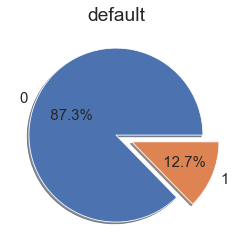

In [53]:
plt.pie(x=train['default'].value_counts(),
       labels=list(train['default'].value_counts().index),
       autopct='%6.1f%%',
       explode=[0, 0.2],
       shadow=True,
       textprops={'fontsize': 15})
plt.title('default')
plt.show()

В нашем наборе несбалансированные данные (один класс превосходит другой в 7 раз на train'е). Попробуем выполнить undersamplig.

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.5s finished


Лучшие параметры модели:  {'C': 50.0, 'max_iter': 223}


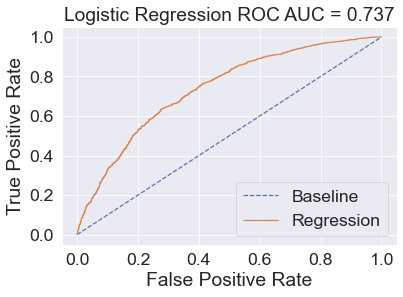

array([[1252,  635],
       [ 607, 1255]], dtype=int64)

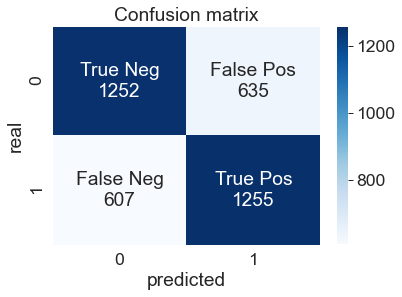

accuracy_score: 0.6687
precision_score: 0.664
recall_score: 0.674
f1_score: 0.669
MSE: 0.3313


In [54]:
und_sampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_und, y_und = und_sampler.fit_resample(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.20, random_state=RANDOM_SEED)

# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000, num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)
model_best.fit(X_train, y_train)
print("Лучшие параметры модели: ", model_best.best_params_)
y_pred = model_best.predict(X_test)

probs = model_best.predict_proba(X_test)
probs = probs[:,1]
show_roc_auc(y_test, probs)


# Строим матрицу ошибок
show_confusion_matrix(y_test, y_pred)

# Остальные метрики
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('precision_score: {}'.format(np.round(precision_score(y_test,y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

Модель явно лучше стала предсказывать класс TrueNegative. Но площадь немного уменьшилась. Попробуем еще одну модель.

## Модель CatBoost

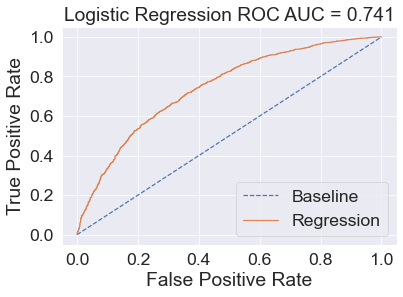

array([[1244,  643],
       [ 576, 1286]], dtype=int64)

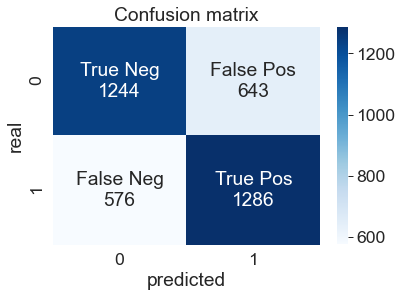

accuracy_score: 0.6748
precision_score: 0.6667
recall_score: 0.6907
f1_score: 0.6784
MSE: 0.3252


In [55]:
cat = CatBoostClassifier(n_estimators=1000,
                         depth=2,
                         logging_level='Silent')

cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
probs = cat.predict_proba(X_test)
probs = probs[:,1]
show_roc_auc(y_test, probs)

# Строим матрицу ошибок
show_confusion_matrix(y_test, y_pred)

# Остальные метрики
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('precision_score: {}'.format(np.round(precision_score(y_test,y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

Результаты примерно такие же как и на прошлом шаге, но площадь чуть больше стала. Для submission возьму эти данные.

# Подготовка итоговых данных

In [56]:
X_fin = test.drop(columns = ['default', 'client_id']).values
y_pred = cat.predict_proba(X_fin)
submission = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
display(submission.sample(10))
display(submission.shape)

,client_id,default
28747,35811,0.541692
28450,96025,0.220888
15496,49788,0.580103
28506,92844,0.366955
7622,14525,0.172704
9886,58034,0.256051
5333,11979,0.292827
33442,33407,0.538122
24197,43625,0.148582
22691,103672,0.420334


(36349, 2)

In [57]:
submission.to_csv('submission.csv', index=False)